### What is Cache-Augmented Generation (CAG)?
CAG is a retrieval-free approach that bypasses the usual step of querying external knowledge sources at inference time. Instead, it preloads relevant documents into the LLM's extended context window, precomputes the model’s key‑value (KV) cache, and reuses this during inference—so the model can generate responses without additional retrieval steps 

In simple terms
**Cache-Augmented Generation (CAG)** is a **retrieval-free optimization of RAG**, designed to make LLM responses faster and cheaper *without losing access to external context*.

Instead of performing **retrieval queries at inference time**, CAG **pre-loads the relevant context into the model once** (before inference) and **stores the model’s internal attention state (KV cache)** so it can be reused for subsequent queries.

---

## 🧠 Let’s unpack this step-by-step

### 🧩 1. Reminder: How normal RAG works

In **RAG**, every time you send a new query:

1. The system searches a vector database (e.g., FAISS, Chroma, Pinecone)
2. Retrieves top-k documents
3. Adds them to the LLM prompt
4. The LLM processes both the retrieved data and your question to answer.

That means:

* Each query repeats the **retrieval + embedding + re-encoding** cost
* The LLM must **re-read all context tokens** every time
* Latency grows with context length and retrieval time

---

### ⚡ 2. How **CAG** improves on this

**Cache-Augmented Generation (CAG)** avoids redundant retrieval and re-encoding by caching the model’s *internal representation* of context.

#### 🧠 Step-by-step:

1. **Preload Context Once**

   * Before answering questions, you feed the model all relevant background data (documents, codebase, knowledge base, etc.).
   * The model reads and encodes these into its attention memory — the **key-value (KV) cache**.

2. **Cache the KV State**

   * The model’s transformer layers generate *keys and values* for every token, used during self-attention.
   * These are stored and reused later (instead of recomputing).

3. **Inference Time (Query Phase)**

   * When a new question arrives, you don’t reload or re-embed the documents.
   * You simply **reuse the cached KV states** — the model “remembers” the context instantly.
   * The model can generate answers *as if it had already read those documents*, but without reprocessing them.

✅ **No retrieval**
✅ **No repeated encoding**
✅ **Lower latency and cost**
✅ **Faster multi-turn interactions**

---

### 🧩 3. Key Concept: KV Cache

Every transformer maintains **Key–Value (KV) pairs** at each layer during attention:

* **Key (K)** = representation of “what I contain”
* **Value (V)** = representation of “what I contribute”
* **Query (Q)** = current input’s request for relevant past info

In normal generation, the LLM recomputes attention for all past tokens.

In **CAG**, these KVs for the “context documents” are **precomputed and stored**, so the LLM just appends new queries to the existing attention window.

Think of it like:

> “The model has already read the textbook. Now it just reads the question and answers immediately — without reopening the book.”

---

## 🏗️ Architecture Overview

```
               ┌────────────────────────────┐
               │  Preload Context (Offline) │
               │   - Embed documents        │
               │   - Run LLM once           │
               │   - Store KV cache         │
               └────────────┬───────────────┘
                            │
                            ▼
   ┌──────────────────────────────────────────────┐
   │             Inference / Query Time           │
   │   - Load precomputed KV cache                │
   │   - Inject user query                       │
   │   - Generate answer instantly                │
   └──────────────────────────────────────────────┘
```

## 🔬 Practical Example

Imagine building a **domain-specific chatbot for a law firm**:

* You preload all legal documents into the LLM context (via cache).
* During daily use, the chatbot answers new queries instantly because it reuses the **cached KV state**.
* It doesn’t re-query a database or re-tokenize the docs each time.

This is **Cache-Augmented Generation** — the model “remembers” efficiently through cache, not retrieval.

---

## 🚀 Benefits

* **Faster inference** (no retrieval latency)
* **Lower cost** (reuse pre-encoded context)
* **Scalable to multi-turn sessions**
* **More stable outputs** (no retrieval randomness)
* **Ideal for static or semi-static corpora**

---

## ⚠️ Limitations

* Cache must fit within the model’s **context window limit** (e.g., 128K or 1M tokens)
* Updating cached data requires recomputing
* Not suitable for *rapidly changing* data sources





In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain.chat_models import init_chat_model

llm=init_chat_model("openai:gpt-4o-mini")

llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001FE4A0CC890>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001FE4A2E76E0>, root_client=<openai.OpenAI object at 0x000001FE47B3C2F0>, root_async_client=<openai.AsyncOpenAI object at 0x000001FE4A533AA0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [2]:
### Cache variable
Model_Cache={}

In [3]:
import time

def cache_model(query):
    start_time=time.time()
    if Model_Cache.get(query):
        print("**CAche Hit**")
        end_time=time.time()
        elapsed_time=end_time-start_time
        print(f"EXECUTION TIME: {elapsed_time:.2f} seconds")
        return Model_Cache.get(query)
    else:
        print("***CACHE MISS – EXECUTING MODEL***")
        start_time = time.time()
        response = llm.invoke(query)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"EXECUTION TIME: {elapsed:.2f} seconds")
        Model_Cache[query] = response
        return response


In [4]:
response=cache_model("hi")
response

***CACHE MISS – EXECUTING MODEL***


EXECUTION TIME: 1.73 seconds


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CWNfHoEtpgz2zVwkhZv0uSgL4dqWg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--79c60541-63fe-4007-bf1d-3a19c277428e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
Model_Cache

{'hi': AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CWNfHoEtpgz2zVwkhZv0uSgL4dqWg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--79c60541-63fe-4007-bf1d-3a19c277428e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [6]:
response=cache_model("hi")
response

**CAche Hit**
EXECUTION TIME: 0.00 seconds


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CWNfHoEtpgz2zVwkhZv0uSgL4dqWg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--79c60541-63fe-4007-bf1d-3a19c277428e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
query="can you give me 500 words on langgraph?"
response =cache_model(query)
print(response)

***CACHE MISS – EXECUTING MODEL***


EXECUTION TIME: 12.08 seconds
content="LangGraph is a powerful and innovative tool designed to enhance and simplify the process of natural language processing (NLP) through the application of graph theory and advanced algorithms. By leveraging the intrinsic relationships within data, LangGraph enables users to create complex linguistic structures that can be utilized across various applications, such as chatbots, sentiment analysis, and automated content generation.\n\nAt its core, LangGraph operates on the premise that language is inherently structured in ways that can be effectively modeled as a graph. In this representation, words and phrases are treated as nodes, while the relationships between them—such as syntactic dependencies, semantic similarities, or contextual relevance—are represented as edges. This graph-based approach allows for a richer understanding of language, as it captures nuances that traditional linear text processing methods might overlook.\n\nOne of the primary 

In [8]:
query="can you give me 500 words on langgraph?"
response =cache_model(query)
print(response)

**CAche Hit**
EXECUTION TIME: 0.00 seconds
content="LangGraph is a powerful and innovative tool designed to enhance and simplify the process of natural language processing (NLP) through the application of graph theory and advanced algorithms. By leveraging the intrinsic relationships within data, LangGraph enables users to create complex linguistic structures that can be utilized across various applications, such as chatbots, sentiment analysis, and automated content generation.\n\nAt its core, LangGraph operates on the premise that language is inherently structured in ways that can be effectively modeled as a graph. In this representation, words and phrases are treated as nodes, while the relationships between them—such as syntactic dependencies, semantic similarities, or contextual relevance—are represented as edges. This graph-based approach allows for a richer understanding of language, as it captures nuances that traditional linear text processing methods might overlook.\n\nOne of

In [9]:
query="give me 500 words on langgraph?"
response =cache_model(query)
print(response)

***CACHE MISS – EXECUTING MODEL***
EXECUTION TIME: 13.57 seconds
content='LangGraph is a state-of-the-art language modeling framework designed to enhance natural language understanding and generation by utilizing graph-based structures. It leverages the concepts of graph theory to represent linguistic data in a way that captures the complex relationships between words, phrases, and ideas. The innovation behind LangGraph lies in its ability to create a multi-dimensional representation of language, moving beyond traditional linear sequences to encapsulate contextual and semantic nuances.\n\nAt its core, LangGraph combines elements of graph neural networks (GNNs) with powerful transformers architectures, facilitating the integration of various linguistic modalities. This hybrid approach allows for a more sophisticated understanding of how words and sentences connect in meaningful ways. Unlike conventional models that primarily operate on sequential data, LangGraph constructs a graph where

### Advanced CAG

In [10]:
from __future__ import annotations
from typing import TypedDict, List, Optional
import time

# ---- LangGraph / LangChain ----
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain.embeddings import HuggingFaceEmbeddings

# ---- FAISS vector stores ----
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [11]:
# ================= CONFIG =================
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # 384-dim
VECTOR_DIM = 384

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

RETRIEVE_TOP_K = 4
CACHE_TOP_K = 3

CACHE_DISTANCE_THRESHOLD = 0.45

# Optional TTL for cache entries (seconds). 0 = disabled.
CACHE_TTL_SEC = 0


In [12]:
# ================= STATE ==================
class RAGState(TypedDict):
    question: str
    normalized_question: str
    context_docs: List[Document]
    answer: Optional[str]
    citations: List[str]
    cache_hit: bool

In [15]:
# ============== GLOBALS ===================
from langchain_huggingface import HuggingFaceEmbeddings
EMBED = HuggingFaceEmbeddings(model_name=EMBED_MODEL)

In [16]:
# ----- QA CACHE (EMPTY, SAFE INIT) -----
qa_index = faiss.IndexFlatL2(VECTOR_DIM)  # distance; lower is better
QA_CACHE = FAISS(
    embedding_function=EMBED,
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

In [17]:
QA_CACHE

In [18]:
# ----- RAG STORE (demo only) -----
RAG_STORE = FAISS.from_texts(
    texts=[
        "LangGraph lets you compose stateful LLM workflows as graphs.",
        "In LangGraph, nodes can be cached; node caching memoizes outputs keyed by inputs for a TTL.",
        "Retrieval-Augmented Generation (RAG) retrieves external context and injects it into prompts.",
        "Semantic caching reuses prior answers when new questions are semantically similar."
    ],
    embedding=EMBED,
)

In [19]:
LLM = ChatOpenAI(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

In [20]:
LLM


ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001FE7913E660>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001FE2F6B6240>, root_client=<openai.OpenAI object at 0x000001FE7913F470>, root_async_client=<openai.AsyncOpenAI object at 0x000001FE7913F3B0>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [21]:
# ================ NODES ===================
def normalize_query(state: RAGState) -> RAGState:
    q = (state["question"] or "").strip()
    state["normalized_question"] = q.lower()
    return state

def semantic_cache_lookup(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    state["cache_hit"] = False  # default

    if not q:
        return state

    # ✅ Guard: FAISS crashes if ntotal == 0 and you ask for k>0
    if getattr(QA_CACHE, "index", None) is None or QA_CACHE.index.ntotal == 0:
        return state

    # For FAISS L2 wrapper, this returns (Document, distance) with lower=better
    hits = QA_CACHE.similarity_search_with_score(q, k=CACHE_TOP_K)
    if not hits:
        return state

    best_doc, dist = hits[0]

    # Optional TTL
    if CACHE_TTL_SEC > 0:
        ts = best_doc.metadata.get("ts")
        if ts is None or (time.time() - float(ts)) > CACHE_TTL_SEC:
            return state

    # L2 distance gate (lower = more similar)
    if dist <= CACHE_DISTANCE_THRESHOLD:
        cached_answer = best_doc.metadata.get("answer")
        if cached_answer:
            state["answer"] = cached_answer
            state["citations"] = ["(cache)"]
            state["cache_hit"] = True

    return state

def respond_from_cache(state: RAGState) -> RAGState:
    return state

def retrieve(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    docs = RAG_STORE.similarity_search(q, k=RETRIEVE_TOP_K)
    state["context_docs"] = docs
    return state

def generate(state: RAGState) -> RAGState:
    q = state["question"]
    docs = state.get("context_docs", [])
    ctx = "\n\n".join([f"[doc-{i}] {d.page_content}" for i, d in enumerate(docs, start=1)])

    system = (
        "You are a precise RAG assistant. Use the context when helpful. "
        "Cite with [doc-i] markers if you use a fact from the context."
    )
    user = f"Question: {q}\n\nContext:\n{ctx}\n\nWrite a concise answer with citations."

    resp = LLM.invoke([{"role": "system", "content": system},
                       {"role": "user", "content": user}])
    state["answer"] = resp.content
    state["citations"] = [f"[doc-{i}]" for i in range(1, len(docs) + 1)]
    return state

def cache_write(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    a = state.get("answer")
    if not q or not a:
        return state

    QA_CACHE.add_texts(
        texts=[q],
        metadatas=[{
            "answer": a,
            "ts": time.time(),
        }]
    )
    return state

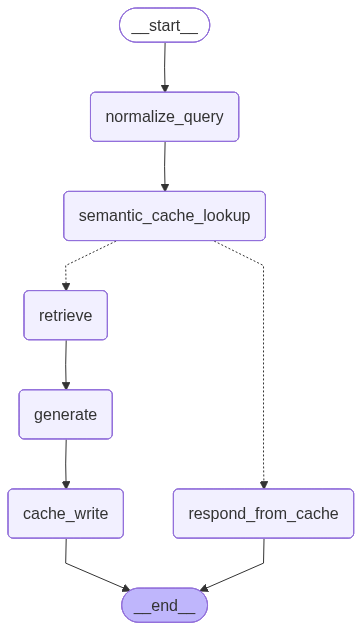

In [22]:
# ============== GRAPH WIRING ==============
graph = StateGraph(RAGState)

graph.add_node("normalize_query", normalize_query)
graph.add_node("semantic_cache_lookup", semantic_cache_lookup)
graph.add_node("respond_from_cache", respond_from_cache)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("cache_write", cache_write)

graph.set_entry_point("normalize_query")
graph.add_edge("normalize_query", "semantic_cache_lookup")

def _branch(state: RAGState) -> str:
    return "respond_from_cache" if state.get("cache_hit") else "retrieve"

graph.add_conditional_edges(
    "semantic_cache_lookup",
    _branch,
    {
        "respond_from_cache": "respond_from_cache",
        "retrieve": "retrieve"
    }
)

graph.add_edge("respond_from_cache", END)
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "cache_write")
graph.add_edge("cache_write", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)
app

In [23]:
# ================= DEMO ===================
if __name__ == "__main__":
    thread_cfg = {"configurable": {"thread_id": "demo-user-1"}}

    q1 = "What is LangGraph ?"
    out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
    print("Answer:", out1["answer"])
    print("Citations:", out1.get("citations"))
    print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph is a framework that allows users to compose stateful workflows for large language models (LLMs) in the form of graphs, enabling the management of complex interactions and data flows [doc-2]. It also features node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-1].
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [24]:
q1 = "Explain about LangGraph ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph is a framework that allows users to compose stateful workflows for large language models (LLMs) in the form of graphs, enabling the management of complex interactions and data flows [doc-2]. It also features node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-1].
Citations: ['(cache)']
Cache hit?: True


In [25]:
q1 = "Explain about LangGraph agents ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph agents are part of a framework that allows users to compose stateful workflows using large language models (LLMs) structured as graphs [doc-2]. These agents can utilize features like node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-1]. Additionally, they can leverage semantic caching to reuse previous answers when new questions are semantically similar, enhancing efficiency [doc-4]. This approach aligns with Retrieval-Augmented Generation (RAG), which retrieves external context to enrich prompts [doc-3].
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [26]:
q1 = "Explain about agents in Langgraph ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph agents are part of a framework that allows users to compose stateful workflows using large language models (LLMs) structured as graphs [doc-2]. These agents can utilize features like node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-1]. Additionally, they can leverage semantic caching to reuse previous answers when new questions are semantically similar, enhancing efficiency [doc-4]. This approach aligns with Retrieval-Augmented Generation (RAG), which retrieves external context to enrich prompts [doc-3].
Citations: ['(cache)']
Cache hit?: True
